In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install duckdb scikit-learn pandas matplotlib joblib
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.4 MB/s eta 0:00:00


In [ ]:
import duckdb
import pandas as pd
import numpy as np
import json, joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from category_encoders.target_encoder import TargetEncoder


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/nyc_inspections_reduced.csv')
print(df.shape)
print(df.head(3))


(274933, 9)
      CAMIS                    DBA   BORO  ZIPCODE       CUISINE DESCRIPTION  \
0  30075445  MORRIS PARK BAKE SHOP  Bronx  10462.0  Bakery Products/Desserts   
1  30075445  MORRIS PARK BAKE SHOP  Bronx  10462.0  Bakery Products/Desserts   
2  30075445  MORRIS PARK BAKE SHOP  Bronx  10462.0  Bakery Products/Desserts   

  INSPECTION DATE  SCORE GRADE CRITICAL FLAG  
0      2023-01-31   21.0   NaN  Not Critical  
1      2023-01-31   21.0   NaN      Critical  
2      2023-01-31   21.0   NaN      Critical  


In [ ]:
con = duckdb.connect()
con.register('ins', df)

# Overall counts and churn of criticals
display(con.sql("""
SELECT
  COUNT(*) AS n_rows,
  SUM(CASE WHEN "CRITICAL FLAG"='Critical' THEN 1 ELSE 0 END) AS n_critical,
  AVG(CASE WHEN "CRITICAL FLAG"='Critical' THEN 1 ELSE 0 END)::DOUBLE AS pct_critical
FROM ins
""").df())

# Top cuisines and their critical rates
display(con.sql("""
SELECT "CUISINE DESCRIPTION" AS cuisine,
       COUNT(*) AS n,
       AVG(CASE WHEN "CRITICAL FLAG"='Critical' THEN 1 ELSE 0 END)::DOUBLE AS critical_rate
FROM ins
GROUP BY 1
HAVING COUNT(*) > 1000
ORDER BY critical_rate DESC
LIMIT 15
""").df())


,n_rows,n_critical,pct_critical
0,274933,154031.0,0.560249


,cuisine,n,critical_rate
0,Bangladeshi,1593,0.627119
1,African,1339,0.604929
2,Indian,4325,0.598613
3,Southeast Asian,1292,0.598297
4,Asian/Asian Fusion,5330,0.595310
5,Chinese,27523,0.591251
6,Korean,4311,0.589886
7,Thai,4233,0.586818
8,Peruvian,1107,0.586269
9,Spanish,6526,0.581827


In [ ]:
def build_next_label(g):
    g = g.sort_values('INSPECTION DATE')
    g['next_is_critical'] = g['CRITICAL FLAG'].shift(-1).eq('Critical').astype('float')
    return g

df2 = df.groupby('CAMIS', group_keys=False).apply(build_next_label)
df2 = df2.dropna(subset=['next_is_critical'])
print(df2['next_is_critical'].mean())  # baseline critical rate


0.5069817009962427


/tmp/ipython-input-4020137277.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = df.groupby('CAMIS', group_keys=False).apply(build_next_label)


In [ ]:
# Rolling features per restaurant
def add_history_feats(g, window=3):
    g = g.sort_values('INSPECTION DATE')
    g['prev_score'] = g['SCORE'].shift(0)  # current score reflects current conditions
    g['prev_is_critical'] = (g['CRITICAL FLAG']=='Critical').astype(int)
    g['hist_crit_rate_w3'] = g['prev_is_critical'].rolling(window, min_periods=1).mean().shift(1)
    g['hist_visits_w3'] = np.arange(len(g))  # simple visit index
    return g

df3 = df2.groupby('CAMIS', group_keys=False).apply(add_history_feats)

# Convert 'INSPECTION DATE' to datetime objects
df3['INSPECTION DATE'] = pd.to_datetime(df3['INSPECTION DATE'])

# Time features
df3['month'] = df3['INSPECTION DATE'].dt.month
df3['year']  = df3['INSPECTION DATE'].dt.year

# Keep a tidy modeling table
features = [
    'prev_score','hist_crit_rate_w3','hist_visits_w3','month','year',
    'CUISINE DESCRIPTION','BORO','GRADE','ZIPCODE'
]
target = 'next_is_critical'

model_df = df3[features + [target]].copy()

/tmp/ipython-input-1359993609.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df3 = df2.groupby('CAMIS', group_keys=False).apply(add_history_feats)


In [ ]:
# Use a fixed year to split the data
split_year = 2024
train_df = model_df[model_df['year'] <= split_year]
test_df  = model_df[model_df['year'] > split_year]

X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_test,  y_test  = test_df.drop(columns=[target]),  test_df[target]

num_cols = ['prev_score','hist_crit_rate_w3','hist_visits_w3','month','year']
cat_cols = ['CUISINE DESCRIPTION','BORO','GRADE','ZIPCODE']

pre = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='ignore', min_frequency=50))
    ]), cat_cols)
])

clf = Pipeline([
    ('prep', pre),
    ('model', LogisticRegression(max_iter=200, class_weight='balanced'))
])

clf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['prev_score',
                                                   'hist_crit_rate_w3',
                                                   'hist_visits_w3', 'month',
                                                   'year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=50))]),
                                                  ['CUISINE DESCRIPTION',
                                                   'BORO', 'GRADE',
                                                   'ZIPCODE'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=200))])

              precision    recall  f1-score   support

         0.0      0.644     0.709     0.675     40313
         1.0      0.587     0.514     0.548     32453

    accuracy                          0.622     72766
   macro avg      0.616     0.611     0.612     72766
weighted avg      0.619     0.622     0.618     72766

ROC AUC: 0.6529575130622355
PR AUC: 0.5720201578577854


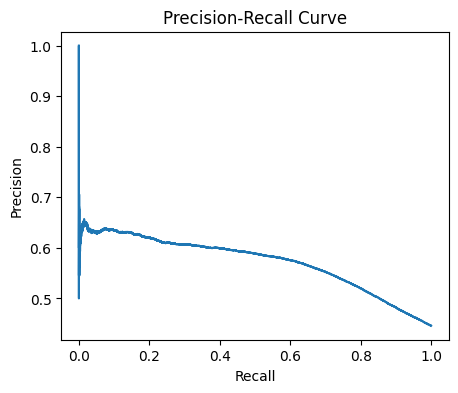

['models/model.pkl']

In [ ]:
proba = clf.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

print(classification_report(y_test, pred, digits=3))
print("ROC AUC:", roc_auc_score(y_test, proba))
print("PR AUC:",  average_precision_score(y_test, proba))

# PR curve for the README
p, r, t = precision_recall_curve(y_test, proba)
plt.figure(figsize=(5,4))
plt.plot(r, p); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve')
plt.show()

# save metrics
metrics = {
    "roc_auc": float(roc_auc_score(y_test, proba)),
    "pr_auc":  float(average_precision_score(y_test, proba))
}
# Create reports directory if it doesn't exist
import os
if not os.path.exists('reports'):
    os.makedirs('reports')
with open('reports/metrics.json','w') as f: json.dump(metrics, f, indent=2)

# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')
joblib.dump(clf, 'models/model.pkl')

In [ ]:
# crude importance: perturb numeric columns
base_auc = roc_auc_score(y_test, proba)
imps = []
for col in num_cols:
    Xt = X_test.copy()
    Xt[col] = np.random.permutation(Xt[col].values)
    proba_t = clf.predict_proba(Xt)[:,1]
    auc_t = roc_auc_score(y_test, proba_t)
    imps.append((col, base_auc - auc_t))
imp_df = pd.DataFrame(imps, columns=['feature','auc_drop']).sort_values('auc_drop', ascending=False)
imp_df.to_csv('reports/feature_importance.csv', index=False)
imp_df.head(10)


,feature,auc_drop
0,prev_score,0.154959
2,hist_visits_w3,0.011985
3,month,0.002070
4,year,0.000000
1,hist_crit_rate_w3,-0.000064


In [ ]:
import json
import joblib
import numpy as np
import pandas as pd
import streamlit as st
from pathlib import Path

# ----------------------------
# Config
# ----------------------------
DATA_PATH = Path("data/nyc_inspections_reduced.csv")
MODEL_PATH = Path("models/model.pkl")
METRICS_PATH = Path("reports/metrics.json")

FEATURES = [
    "prev_score", "hist_crit_rate_w3", "hist_visits_w3", "month", "year",
    "CUISINE DESCRIPTION", "BORO", "GRADE", "ZIPCODE"
]

st.set_page_config(page_title="InspectNYC — Critical Violation Risk", layout="wide")

# ----------------------------
# Helpers
# ----------------------------
def add_history_and_features(df: pd.DataFrame) -> pd.DataFrame:
    """Rebuild features to match training-time logic."""
    df = df.copy()
    df["INSPECTION DATE"] = pd.to_datetime(df["INSPECTION DATE"], errors="coerce")
    df = df.dropna(subset=["INSPECTION DATE", "CAMIS"])
    df = df.sort_values(["CAMIS", "INSPECTION DATE"])

    # current row flags (used to build rolling history)
    df["prev_is_critical"] = (df["CRITICAL FLAG"] == "Critical").astype(int)
    # rolling stats within each restaurant
    def _add_roll(g):
        g = g.sort_values("INSPECTION DATE")
        g["hist_crit_rate_w3"] = g["prev_is_critical"].rolling(3, min_periods=1).mean().shift(1)
        g["hist_visits_w3"] = np.arange(len(g))
        return g

    df = df.groupby("CAMIS", group_keys=False).apply(_add_roll)

    # score, time features
    df["prev_score"] = pd.to_numeric(df["SCORE"], errors="coerce")
    df["month"] = df["INSPECTION DATE"].dt.month
    df["year"] = df["INSPECTION DATE"].dt.year

    # tidy
    keep_cols = list(set(FEATURES + ["CAMIS", "DBA", "INSPECTION DATE"]))
    keep_cols = [c for c in keep_cols if c in df.columns]
    df = df[keep_cols].dropna(subset=["prev_score", "hist_crit_rate_w3", "month", "year"])

    return df

@st.cache_data(show_spinner=False)
def load_data():
    df = pd.read_csv(DATA_PATH, low_memory=False)
    return df

@st.cache_resource(show_spinner=False)
def load_model():
    return joblib.load(MODEL_PATH)

def load_metrics():
    try:
        with open(METRICS_PATH, "r") as f:
            return json.load(f)
    except Exception:
        return None

def latest_snapshot_for_scoring(df_feat: pd.DataFrame) -> pd.DataFrame:
    """Take the most recent inspection per restaurant as the basis for 'next inspection' prediction."""
    idx = df_feat.groupby("CAMIS")["INSPECTION DATE"].idxmax()
    snap = df_feat.loc[idx].copy()
    return snap

# ----------------------------
# App
# ----------------------------
st.title("InspectNYC — Predicting Critical Health Violations")
st.write("Rank restaurants by risk so inspectors can prioritize the next visit.")

# File checks
missing = []
if not DATA_PATH.exists(): missing.append(str(DATA_PATH))
if not MODEL_PATH.exists(): missing.append(str(MODEL_PATH))
if missing:
    st.error(f"Missing required files: {', '.join(missing)}")
    st.stop()

with st.spinner("Loading data and model..."):
    raw = load_data()
    model = load_model()
    metrics = load_metrics()

# Build features
with st.spinner("Building features..."):
    feat = add_history_and_features(raw)
    snap = latest_snapshot_for_scoring(feat)

# Sidebar controls
st.sidebar.header("Filters")
boroughs = ["All"] + sorted([b for b in snap["BORO"].dropna().unique()])
boro_choice = st.sidebar.selectbox("Borough", boroughs, index=0)

# limit cuisines to common ones for the UI
top_cuisines = (
    snap["CUISINE DESCRIPTION"]
    .value_counts()
    .head(30)
    .index.tolist()
)
cuisine_filter = st.sidebar.multiselect("Cuisine (top 30 by count)", top_cuisines, default=[])

zip_filter = st.sidebar.text_input("ZIP code (exact match or comma-separated)", "")

threshold = st.sidebar.slider("Risk threshold (probability)", 0.05, 0.95, 0.35, 0.01)
top_n = st.sidebar.number_input("Top N to display", min_value=10, max_value=1000, value=200, step=10)

# Apply filters
view = snap.copy()
if boro_choice != "All":
    view = view[view["BORO"] == boro_choice]
if cuisine_filter:
    view = view[view["CUISINE DESCRIPTION"].isin(cuisine_filter)]
if zip_filter.strip():
    zips = [z.strip() for z in zip_filter.split(",") if z.strip()]
    view = view[view["ZIPCODE"].astype(str).isin(zips)]

if view.empty:
    st.warning("No rows after filters. Relax filters or pick a different borough/cuisine.")
    st.stop()

# Score
X = view[FEATURES].copy()
proba = model.predict_proba(X)[:, 1]
view = view.assign(risk=proba)
view = view.sort_values("risk", ascending=False)

# Headline metrics
col1, col2 = st.columns(2)
col1.metric("Restaurants scored", f"{len(view):,}")
if metrics:
    col2.metric("Model ROC AUC", f"{metrics.get('roc_auc', 0):.3f}")
else:
    col2.write("No metrics.json found.")

# Table
st.subheader("Highest-risk venues")
risk_cut = view[view["risk"] >= threshold]
table = risk_cut.head(top_n).copy()
pretty_cols = ["CAMIS", "DBA", "BORO", "ZIPCODE", "CUISINE DESCRIPTION", "INSPECTION DATE", "risk"]
table = table[pretty_cols].rename(columns={
    "DBA": "Name",
    "BORO": "Borough",
    "ZIPCODE": "ZIP",
    "CUISINE DESCRIPTION": "Cuisine",
    "INSPECTION DATE": "Last Inspection",
    "risk": "Predicted Risk"
})
table["Predicted Risk"] = table["Predicted Risk"].round(3)

st.dataframe(table, use_container_width=True, height=480)

# Download
csv_bytes = table.to_csv(index=False).encode("utf-8")
st.download_button(
    "Download table as CSV",
    data=csv_bytes,
    file_name="inspectnyc_high_risk.csv",
    mime="text/csv"
)

# Notes
with st.expander("Notes"):
    st.markdown(
        """
- **Prediction target:** “Will the **next** inspection be critical?”
- Scores reflect the model’s estimated probability based on a restaurant’s history, geography, cuisine, and seasonality.
- Use a **lower threshold** for high-recall (catch more risky venues) or a **higher threshold** for high precision.
        """
    )
